In [ ]:
import os
import re
import cv2
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/ 
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !kaggle datasets download -d mbornoe/lisa-traffic-light-dataset -p /content/drive/MyDrive/Datasets/
# !unzip -q /content/drive/MyDrive/Datasets/lisa-traffic-light-dataset.zip -d /content/drive/MyDrive/Datasets/lisa  

In [ ]:
CLASS_LABEL_MAP = {
    "stop": 1,        # red
    "warning": 2,     # yellow
    "go": 3,          # green
    "goForward": 4,   # unknown
    "goLeft": 4,      # unknown
    "warningLeft": 4, # unknown
    "stopLeft": 4,    # unknown
}

LABEL_CLASS_MAP = {
    1: "red",
    2: "yellow",     
    3: "green",          
    4: "unknown",
}

In [ ]:
def img_show(img):
    img_to_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(dpi=100)
    plt.axis('off')
    plt.imshow(img_to_show)
    plt.show()

In [ ]:
def createDataFrame(files):
    df_all = []

    for f in files:
        df = pd.read_csv(f, ";")

        # change 'Filename' value to absolute path
        def abs_path(filename, f_path):
            f_path_split = f_path.split('/Annotations/Annotations/')
            root_dir = f_path_split[0]
            type_dir = f_path_split[1].split('/')[0] # dayTrain, nightSequence1, ...
            clip_dir = f_path_split[1].split('/')[1:-1] # dayClip1
            img_name = filename.split("/")[-1]
            
            return os.path.join(root_dir, 
                                *[type_dir]*2,
                                *clip_dir,
                                'frames', 
                                img_name)

        df["Filename"] = df["Filename"].apply(abs_path, args=(f,))
        df_all.append(df)

    df_all_concat = pd.concat(df_all, ignore_index=True)
    df_all_concat.drop_duplicates(inplace=True, ignore_index=True)

    return df_all_concat

In [ ]:
class LISADataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        # load all annotation files
        annotationFiles = glob.glob(os.path.join(root_dir, "Annotations/Annotations", "**/*BOX.csv"), recursive=True)
        self.annotations = createDataFrame(annotationFiles)
        
        # images
        self.imgs = self.annotations["Filename"].unique()

        # groupby_frame
        self.annotations_groupby_frame = self.annotations.groupby("Filename")

    def getAnnotation(self, img_path):
        annotation = self.annotations_groupby_frame.get_group(img_path)
        return annotation[
            [
                "Filename",
                "Annotation tag",
                "Upper left corner X",
                "Upper left corner Y",
                "Lower right corner X",
                "Lower right corner Y",
            ]
        ]

    def __getitem__(self, idx):
        # load image at that index
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        # print(img_path)
        if image is None:
            raise FileNotFoundError('Incorrect path')
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annotation = self.getAnnotation(img_path)

        # get bounding box coordinates for each traffic light
        coords = []
        state = []
        affect = []
        for _, row in annotation.iterrows():
            xmin = row["Upper left corner X"]
            xmax = row["Lower right corner X"]
            ymin = row["Upper left corner Y"]
            ymax = row["Lower right corner Y"]
            coords.append([xmin, ymin, xmax, ymax])
            state.append(CLASS_LABEL_MAP[row["Annotation tag"]])
            if CLASS_LABEL_MAP[row["Annotation tag"]] > 3:
                affect.append(False)
            else:
                affect.append(True)

        sample = {
            "image": image,
            "coords": coords,
            "state": state,
            "affect": affect
        }

        return sample

    def __len__(self):
        return len(self.imgs)

In [ ]:
lisa_dataset = LISADataset(root_dir='/content/drive/MyDrive/Datasets/lisa/')
# lisa_dataset[1000]

14836  :  /content/drive/MyDrive/Datasets/lisa/dayTrain/dayTrain/dayClip5/frames/dayClip5--02288.jpg


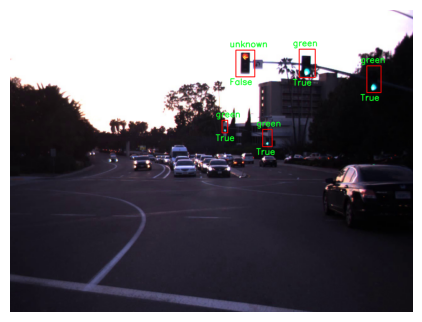

434  :  /content/drive/MyDrive/Datasets/lisa/daySequence1/daySequence1/frames/daySequence1--00564.jpg


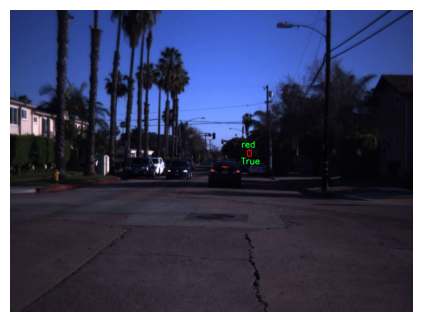

3967  :  /content/drive/MyDrive/Datasets/lisa/daySequence2/daySequence2/frames/daySequence2--01157.jpg


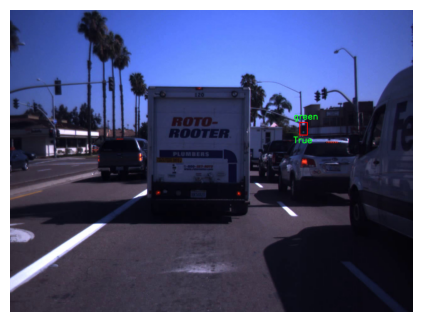

32272  :  /content/drive/MyDrive/Datasets/lisa/nightTrain/nightTrain/nightClip2/frames/nightClip2--00841.jpg


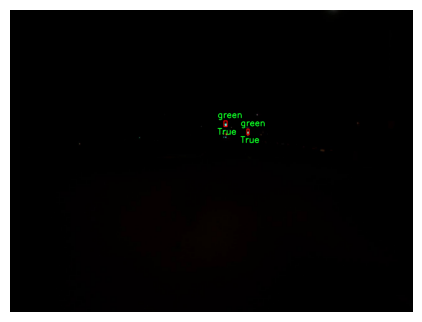

19434  :  /content/drive/MyDrive/Datasets/lisa/dayTrain/dayTrain/dayClip9/frames/dayClip9--00136.jpg


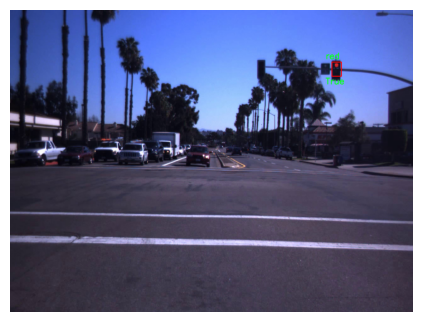

33730  :  /content/drive/MyDrive/Datasets/lisa/nightTrain/nightTrain/nightClip3/frames/nightClip3--00396.jpg


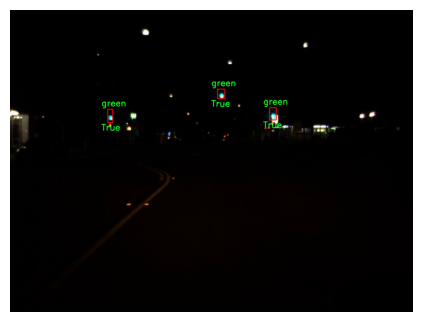

31517  :  /content/drive/MyDrive/Datasets/lisa/nightTrain/nightTrain/nightClip1/frames/nightClip1--00490.jpg


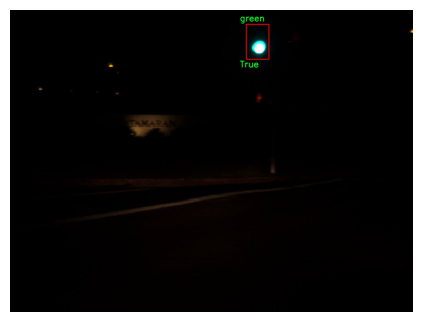

18621  :  /content/drive/MyDrive/Datasets/lisa/dayTrain/dayTrain/dayClip8/frames/dayClip8--00289.jpg


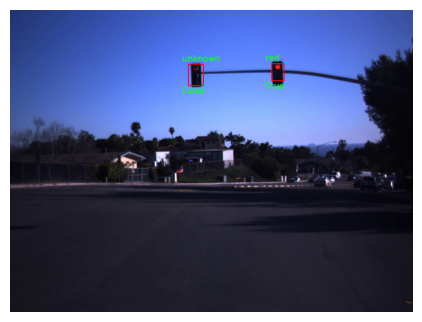

17135  :  /content/drive/MyDrive/Datasets/lisa/dayTrain/dayTrain/dayClip7/frames/dayClip7--01510.jpg


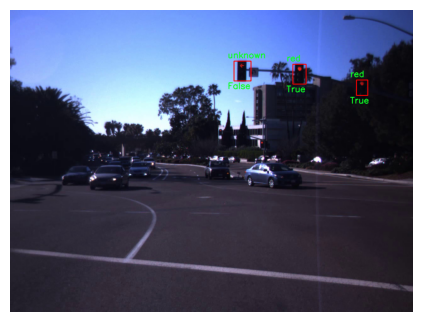

9254  :  /content/drive/MyDrive/Datasets/lisa/dayTrain/dayTrain/dayClip1/frames/dayClip1--01788.jpg


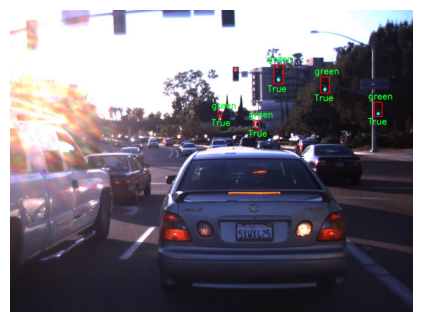

In [ ]:
random_ids = np.random.choice(len(lisa_dataset), 10)
for id in random_ids:
    img = lisa_dataset[id]['image']
    i = 0
    for coord in lisa_dataset[id]['coords']:
        cv2.rectangle(img, (coord[0], coord[1]), (coord[2], coord[3]), color=(0, 0, 255), thickness=2)
        state = LABEL_CLASS_MAP[(lisa_dataset[id]['state'][i])]
        affect = str(lisa_dataset[id]['affect'][i])
        cv2.putText(img, state, (coord[0]-20, coord[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.putText(img, affect, (coord[0]-20, coord[3]+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        i += 1
    print(id,' : ',lisa_dataset.imgs[id])
    img_show(img)